# Autocorrelation and Crosscorrelation
**Autocorrelation** measures the similarity between a time series and a lagged version of itself over successive time intervals. It helps in identifying repeating patterns or periodic signals within the data. 

**Crosscorrelation**, on the other hand, measures the similarity between two different time series as a function of the lag of one relative to the other. 

In the context of SSA, these metrics are useful for analysing the underlying structure and relationships within simulated time series data.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tqdm
from sympy import sqrt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
# Import all the functions from the 'src' directory, we import all the functions from each module so we can use them straight away
from ssa_simulation import simulate_two_telegraph_model_systems
from ssa_analysis import *
from ssa_classification import *
from utils.load_data import load_and_split_data
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We directly take data that was generated for a fixed mean

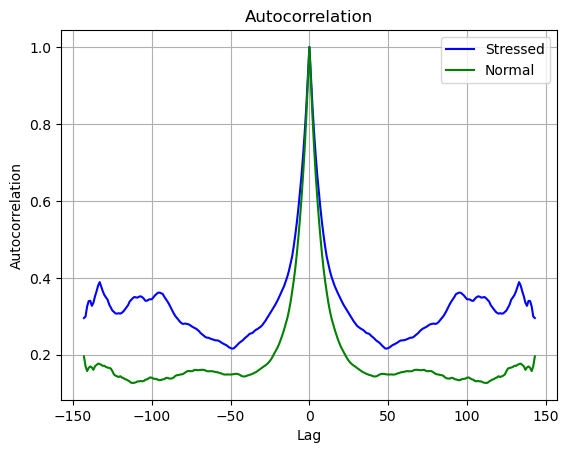

In [4]:
# Define system parameters
mu_target = 10.0  

# Define activation/deactivation rates for two conditions
sigma_u_stress, sigma_b_stress = 18.0, 0.01  # Stressed Condition
sigma_u_normal, sigma_b_normal = 9.0, 0.02   # Normal Condition

# Define degradation rates
d_stress = d_normal = 0.12

# Compute corresponding transcription rates (rho) using the given formula
rho_stress = (mu_target * d_stress * (sigma_u_stress + sigma_b_stress)) / sigma_b_stress
rho_normal = (mu_target * d_normal * (sigma_u_normal + sigma_b_normal)) / sigma_b_normal

# Updated parameter sets ensuring similar mean mRNA levels
parameter_sets = [
    {"sigma_u": sigma_u_stress, "sigma_b": sigma_b_stress, "rho": rho_stress, "d": d_stress, "label": 0},
    {"sigma_u": sigma_u_normal, "sigma_b": sigma_b_normal, "rho": rho_normal, "d": d_normal, "label": 1},
]

output_file = "data/mRNA_trajectories_mean_fixed.csv"
df_results = pd.read_csv(output_file)

# Extract mRNA trajectories for each condition
stress_trajectories = df_results[df_results['label'] == 0].iloc[:, 1:].values  # Stressed Condition
normal_trajectories = df_results[df_results['label'] == 1].iloc[:, 1:].values  # Normal condition

# Find the time index at which steady state is reached
steady_state_time_stress, steady_state_index_stress = find_steady_state(parameter_sets[0])
steady_state_time_normal, steady_state_index_normal = find_steady_state(parameter_sets[1])

# Extract steady-state portions
steady_state_traj_stress = stress_trajectories[:, steady_state_index_stress:]
steady_state_traj_normal = normal_trajectories[:, steady_state_index_normal:]

ac_stress, lags_stress = autocrosscorr(yA=steady_state_traj_stress)
ac_normal, lags_normal = autocrosscorr(yA=steady_state_traj_normal)
plt.figure()
plt.plot(lags_stress, np.nanmean(ac_stress, axis=0), color="blue", label="Stressed")
plt.plot(lags_normal, np.nanmean(ac_normal, axis=0), color="green", label="Normal")
plt.legend()
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation")
plt.grid()
plt.show()

Cross-correlation between 2 signals

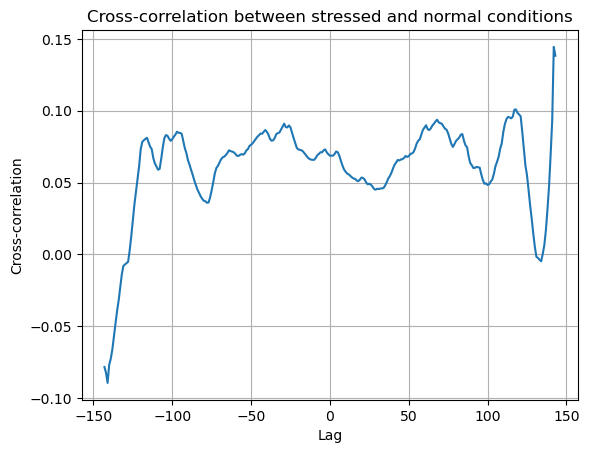

In [ ]:
# Find and plot the cross-correlation between the two conditions
ac, lags = autocrosscorr(yA=steady_state_traj_normal, yB=steady_state_traj_stress)
plt.figure()
plt.plot(lags, np.nanmean(ac, axis=0))
plt.xlabel("Lag")
plt.ylabel("Cross-correlation")
plt.title("Cross-correlation between stressed and normal conditions")
plt.grid()
plt.show()

## Autocorrelation based on System Parameters
Get the autocorrelation based on system parameters, based on the equation:


$\displaystyle ACmRNA = \frac{\left(d \rho \sigma_{u} e^{t \left(d - \sigma_{b} - \sigma_{u}\right)} - \left(\sigma_{b} + \sigma_{u}\right) \left(- d^{2} + \rho \sigma_{u} + \left(\sigma_{b} + \sigma_{u}\right)^{2}\right)\right) e^{- d t}}{\left(d - \sigma_{b} - \sigma_{u}\right) \left(d \left(\sigma_{b} + \sigma_{u}\right) + \rho \sigma_{u} + \left(\sigma_{b} + \sigma_{u}\right)^{2}\right)}$

In [77]:
# Importing necessary modules 
import sympy as sp
from sympy import init_printing
from scipy.optimize import fsolve
import numpy as np

# Define symbols
rho, mu, sigma_sq, d, sigma_u, sigma_b, t = sp.symbols(
    'rho mu sigma_sq d sigma_u sigma_b t', real=True, positive=True
)
init_printing(use_unicode=True)

# Define the equations
def equations(vars, sigma_u, sigma_b, d, mu_target, variance_target, autocorr_target):
    rho = vars[0]

    # Mean equation
    mean_eqn = sigma_b * rho / (d * (sigma_b + sigma_u))

    # Variance equation
    variance_eqn = (
        sigma_b * rho / (d * (sigma_b + sigma_u)) +
        ((sigma_u * sigma_b) * rho**2 / (d * (sigma_b + sigma_u + d) * (sigma_u + sigma_b)**2))
    )

    # Autocorrelation equation
    ACmRNA_eq = sp.exp(-d * t) * (
    d * sp.exp((d - sigma_u - sigma_b) * t) * rho * sigma_u
    - (sigma_u + sigma_b) * (-d**2 + rho * sigma_u + (sigma_u + sigma_b) ** 2)
    ) / (
        (d - sigma_u - sigma_b) * (rho * sigma_u + d * (sigma_u + sigma_b) + (sigma_u + sigma_b) ** 2)
    )

    # Autocorrelation equation evaluated at a specific time point, say t = 1 for simplicity
    autocorr_eqn = ACmRNA_eq.subs(t, 1)

    # Define the equations to be solved
    eq1 = mean_eqn - mu_target
    eq2 = variance_eqn - variance_target
    eq3 = autocorr_eqn - autocorr_target

    return [eq3]

# Target autocorrelation
autocorr_target = 0.5  # Example target autocorrelation at t = 1
variance_target = 500.0
mu_target = 60.0

# Define activation/deactivation rates and degradation rates for the conditions
parameters = {
    "stress": {"sigma_u": 2.5, "sigma_b": 0.9, "d": 1.0},
    "normal": {"sigma_u": 2.5, "sigma_b": 1.0, "d": 1.0}
}

# Store positive rho values for both conditions
rho_values = {}

for condition, param_set in parameters.items():
    # Initial guess for rho this is important to finding a solution that satisfies the equations
    rho_ig = np.arange(1, 10000, 10)
    # sigma_b_ig = np.arange(1, 10000, 10)
    initial_guesses = rho_ig
    
    for initial_guess in initial_guesses:
        solution = fsolve(equations, initial_guess, args=(
            param_set['sigma_u'], param_set['sigma_b'], param_set['d'], mu_target, variance_target, autocorr_target
        ))
        print(f'Solution: {solution}')

        solved_equations = equations(solution, param_set['sigma_u'], param_set['sigma_b'], param_set['d'], mu_target, variance_target, autocorr_target)
        print(f'Solved equation: {solved_equations}')

        # Check if the solved equation is close to zero
        if -1e-6 < solved_equations[0] < 1e-6:
            if solution[0] > 0:
                print('Positive solution found with different initial guesses.')
                print(f"Solution for {condition} condition: {solution}")
                rho_values[condition] = solution[0]
                # sigma_b_values[condition] = solution[1]
                #DEBUG
                print(f'Solution: {solution}, Solved equation: {solved_equations}')

                break

# Output the results
print("Calculated rho values:", rho_values)

# Updated Parameter Sets using the calculated rho values
parameter_sets = [
    {"sigma_u": parameters["stress"]["sigma_u"], 
     "sigma_b": parameters["stress"]["sigma_b"], 
     "rho": rho_values["stress"], 
     "d": parameters["stress"]["d"], 
     "label": 0},
     
    {"sigma_u": parameters["normal"]["sigma_u"], 
     "sigma_b": parameters["normal"]["sigma_b"], 
     "rho": rho_values["normal"], 
     "d": parameters["normal"]["d"], 
     "label": 1}
]

Solution: [108.94420025]
Solved equation: [0]
Positive solution found with different initial guesses.
Solution for stress condition: [108.94420025]
Solution: [108.94420025], Solved equation: [0]
Solution: [281.93936727]
Solved equation: [-1.66533453693773e-16]
Positive solution found with different initial guesses.
Solution for normal condition: [281.93936727]
Solution: [281.93936727], Solved equation: [-1.66533453693773e-16]
Calculated rho values: {'stress': 108.9442002484079, 'normal': 281.93936727488204}


In [85]:
###### Fix the mean, var, and autocorr values for the two conditions
# Importing necessary modules 
import sympy as sp
from sympy import init_printing
from scipy.optimize import fsolve
import numpy as np

# Define symbols
rho, mu, sigma_sq, d, sigma_u, sigma_b, t = sp.symbols(
    'rho mu sigma_sq d sigma_u sigma_b t', real=True, positive=True
)
init_printing(use_unicode=True)

# Define the equations
def equations(vars, sigma_u, sigma_b, d, mu_target, variance_target, autocorr_target):
    rho = vars[0]
    sigma_b = vars[1]
    # sigma_u = vars[2]

    # Mean equation
    mean_eqn = sigma_b * rho / (d * (sigma_b + sigma_u))

    # Variance equation
    variance_eqn = (
        sigma_b * rho / (d * (sigma_b + sigma_u)) +
        ((sigma_u * sigma_b) * rho**2 / (d * (sigma_b + sigma_u + d) * (sigma_u + sigma_b)**2))
    )

    # Autocorrelation equation
    ACmRNA_eq = sp.exp(-d * t) * (
    d * sp.exp((d - sigma_u - sigma_b) * t) * rho * sigma_u
    - (sigma_u + sigma_b) * (-d**2 + rho * sigma_u + (sigma_u + sigma_b) ** 2)
    ) / (
        (d - sigma_u - sigma_b) * (rho * sigma_u + d * (sigma_u + sigma_b) + (sigma_u + sigma_b) ** 2)
    )

    # Autocorrelation equation evaluated at a specific time point, say t = 1 for simplicity
    autocorr_eqn = ACmRNA_eq.subs(t, 1)

    # Define the equations to be solved
    eq1 = mean_eqn - mu_target
    eq2 = variance_eqn - variance_target
    eq3 = autocorr_eqn - autocorr_target

    return [eq1, eq3]

# Target autocorrelation
autocorr_target = 0.5  # Example target autocorrelation at t = 1
variance_target = 500.0
mu_target = 60.0

# Define activation/deactivation rates and degradation rates for the conditions
parameters = {
    "stress": {"sigma_u": 2.6, "sigma_b": 0.9, "d": 1.0},
    "normal": {"sigma_u": 2.5, "sigma_b": 1.0, "d": 1.0}
}

# Store positive rho values for both conditions
rho_values = {}
sigma_b_values = {}
# sigma_u_values = {}

for condition, param_set in parameters.items():
    # Initial guess for rho this is important to finding a solution that satisfies the equations
    rho_ig = np.arange(10, 1000, 10)
    sigma_b_ig = np.arange(10, 1000, 10)
    # sigma_u_ig = np.arange(1, 1000, 10)
    initial_guesses = [(rho, sigma_b) for rho in rho_ig for sigma_b in sigma_b_ig]
    
    for initial_guess in initial_guesses:
        solution = fsolve(equations, initial_guess, args=(
            param_set['sigma_u'], param_set['sigma_b'], param_set['d'], mu_target, variance_target, autocorr_target
        ))
        print(f'Solution: {solution}')

        solved_equations = equations(solution, param_set['sigma_u'], param_set['sigma_b'], param_set['d'], mu_target, variance_target, autocorr_target)
        print(f'Solved equation: {solved_equations}')

        # Check if the solved equation is close to zero
        if -1e-6 < solved_equations[0] < 1e-6 and -1e-6 < solved_equations[1] < 1e-6:
            if solution[0] > 0 and solution[1] > 0:
                print('Positive solution found with different initial guesses.')
                print(f"Solution for {condition} condition: {solution}")
                rho_values[condition] = solution[0]
                sigma_b_values[condition] = solution[1]
                # sigma_u_values[condition] = solution[2]
                #DEBUG
                print(f'Solution: {solution}, Solved equation: {solved_equations}')

                break

# Output the results
print("Calculated rho values:", rho_values)
print("Calculated sigma_b values:", sigma_b_values)
# print("Calculated sigma_u values:", sigma_u_values)

# Updated Parameter Sets using the calculated rho values
parameter_sets = [
    {"sigma_u": parameters["stress"]["sigma_u"], 
     "sigma_b": sigma_b_values["stress"], 
     "rho": rho_values["stress"], 
     "d": parameters["stress"]["d"], 
     "label": 0},
     
    {"sigma_u": parameters["normal"]["sigma_u"], 
     "sigma_b": sigma_b_values["normal"], 
     "rho": rho_values["normal"], 
     "d": parameters["normal"]["d"], 
     "label": 1}
]

Solution: [10. 10.]
Solved equation: [-52.06349206349206, -0.127942661533373]
Solution: [10. 20.]
Solved equation: [-51.150442477876105, -0.131328907931693]
Solution: [10. 30.]
Solved equation: [-50.79754601226994, -0.131850631582933]
Solution: [10. 40.]
Solved equation: [-50.61032863849765, -0.131998476671810]
Solution: [10. 50.]
Solved equation: [-50.49429657794677, -0.132055412200401]
Solution: [10. 60.]
Solved equation: [-50.415335463258785, -0.132081811675793]
Solution: [10. 70.]
Solved equation: [-50.358126721763085, -0.132095679232745]
Solution: [10. 80.]
Solved equation: [-50.31476997578692, -0.132103647791098]
Solution: [10. 90.]
Solved equation: [-50.28077753779698, -0.132108547370535]
Solution: [ 10. 100.]
Solved equation: [-50.253411306042885, -0.132111723615418]
Solution: [ 10. 110.]
Solved equation: [-50.230905861456485, -0.132113872063121]
Solution: [ 10. 120.]
Solved equation: [-50.21207177814029, -0.132115376895120]
Solution: [ 10. 130.]
Solved equation: [-50.196078431

/tmp/ipykernel_1654302/1109557950.py:31: RuntimeWarning: invalid value encountered in multiply
  d * sp.exp((d - sigma_u - sigma_b) * t) * rho * sigma_u
/tmp/ipykernel_1654302/1109557950.py:71: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  solution = fsolve(equations, initial_guess, args=(


Solution: [ 10. 250.]
Solved equation: [-50.102929532858276, -0.132119965617277]
Solution: [ 10. 260.]
Solved equation: [-50.0990099009901, -0.132120030823715]
Solution: [ 10. 270.]
Solved equation: [-50.0953778429934, -0.132120086813573]
Solution: [ 10. 280.]
Solved equation: [-50.09200283085634, -0.132120135159287]
Solution: [ 10. 290.]
Solved equation: [-50.08885850991114, -0.132120177122060]
Solution: [ 10. 300.]
Solved equation: [-50.08592200925314, -0.132120213721417]
Solution: [ 10. 310.]
Solved equation: [-50.083173384516954, -0.132120245787559]
Solution: [ 10. 320.]
Solved equation: [-50.080595164290145, -0.132120274001136]
Solution: [ 10. 330.]
Solved equation: [-50.07817197835237, -0.132120298923757]
Solution: [ 10. 340.]
Solved equation: [-50.075890251021605, -0.132120321021588]
Solution: [ 10. 350.]
Solved equation: [-50.073737946681796, -0.132120340683750]
Solution: [ 10. 360.]
Solved equation: [-50.071704357418646, -0.132120358236778]
Solution: [ 10. 370.]
Solved equatio

/tmp/ipykernel_1654302/1109557950.py:71: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  solution = fsolve(equations, initial_guess, args=(


Solution: [115.73491009   2.79886211]
Solved equation: [-0.0010505384690517872, -0.0580246093668474]
Solution: [107.46079096   3.28687316]
Solved equation: [-0.00040767223224946747, -0.0668766688860049]
Solution: [50. 30.]
Solved equation: [-13.987730061349694, -0.130885470298845]
Solution: [50. 40.]
Solved equation: [-13.051643192488264, -0.131542091286864]
Solution: [50. 50.]
Solved equation: [-12.471482889733842, -0.131806311653081]
Solution: [50. 60.]
Solved equation: [-12.076677316293932, -0.131931723759256]
Solution: [50. 70.]
Solved equation: [-11.790633608815426, -0.131998524551102]
Solution: [50. 80.]
Solved equation: [-11.573849878934624, -0.132037253575800]
Solution: [50. 90.]
Solved equation: [-11.40388768898488, -0.132061211519412]
Solution: [ 50. 100.]
Solved equation: [-11.267056530214425, -0.132076809768819]
Solution: [ 50. 110.]
Solved equation: [-11.154529307282417, -0.132087394099828]
Solution: [ 50. 120.]
Solved equation: [-11.060358890701465, -0.132094825471120]
So

/tmp/ipykernel_1654302/1109557950.py:71: RuntimeWarning: The number of calls to function has reached maxfev = 600.
  solution = fsolve(equations, initial_guess, args=(


Solution: [223.30560743   0.9552734 ]
Solved equation: [0.0004225330993463672, -0.00293749495198914]
Solution: [90. 20.]
Solved equation: [19.646017699115035, -0.126926959199919]
Solution: [90. 30.]
Solved equation: [22.822085889570545, -0.130071324200328]
Solution: [90. 40.]
Solved equation: [24.50704225352112, -0.131131096537709]
Solution: [90. 50.]
Solved equation: [25.551330798479086, -0.131574180252486]
Solution: [90. 60.]
Solved equation: [26.26198083067092, -0.131789041683891]
Solution: [90. 70.]
Solved equation: [26.776859504132233, -0.131904993120205]
Solution: [90. 80.]
Solved equation: [27.167070217917683, -0.131972793707107]
Solution: [90. 90.]
Solved equation: [27.473002159827217, -0.132014981775338]
Solution: [ 90. 100.]
Solved equation: [27.71929824561404, -0.132042564415218]
Solution: [ 90. 110.]
Solved equation: [27.92184724689166, -0.132061338959120]
Solution: [ 90. 120.]
Solved equation: [28.091353996737368, -0.132074551852812]
Solution: [ 90. 130.]
Solved equation: 

Simulating Telegraph Model Systems:   0%|          | 0/2 [00:00<?, ?it/s]

Running simulations on 12 cores...
System 1 parameters: {'sigma_u': 2.6, 'sigma_b': 0.8897525662050808, 'rho': 235.32964323478976, 'd': 1.0, 'label': 0}


Simulating Telegraph Model Systems:  50%|█████     | 1/2 [00:40<00:40, 40.02s/it]

Running simulations on 12 cores...
System 2 parameters: {'sigma_u': 2.5, 'sigma_b': 0.9784854259542611, 'rho': 213.29814422011648, 'd': 1.0, 'label': 1}


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [01:20<00:00, 40.14s/it]



=== Statistical Report ===

📊 **Steady-State Statistics:**
  Stressed Condition (after 10.0 min):
    - Mean mRNA Count: 59.24
    - Variance: 2342.92

  Normal Condition (after 10.0 min):
    - Mean mRNA Count: 59.34
    - Variance: 2091.52
=== SVM (RBF Kernel) Classification Accuracy: 0.60 ===
=== Random Forest Accuracy: 0.57 ===


/home/ianyang/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


=== Logistic Regression Accuracy: 0.53 ===
=== Random Classifier Accuracy: 0.54 ===


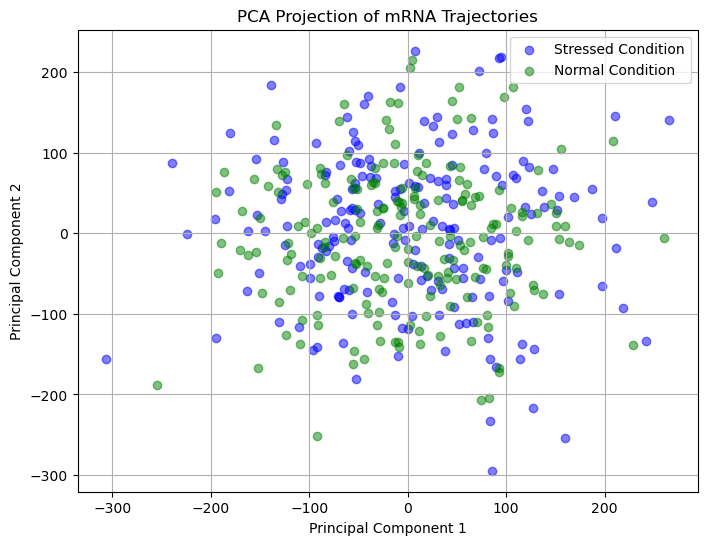

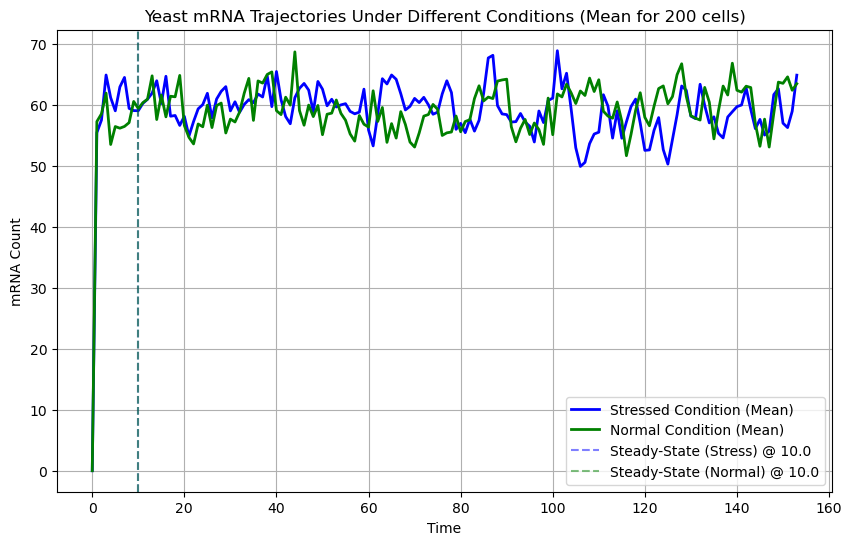

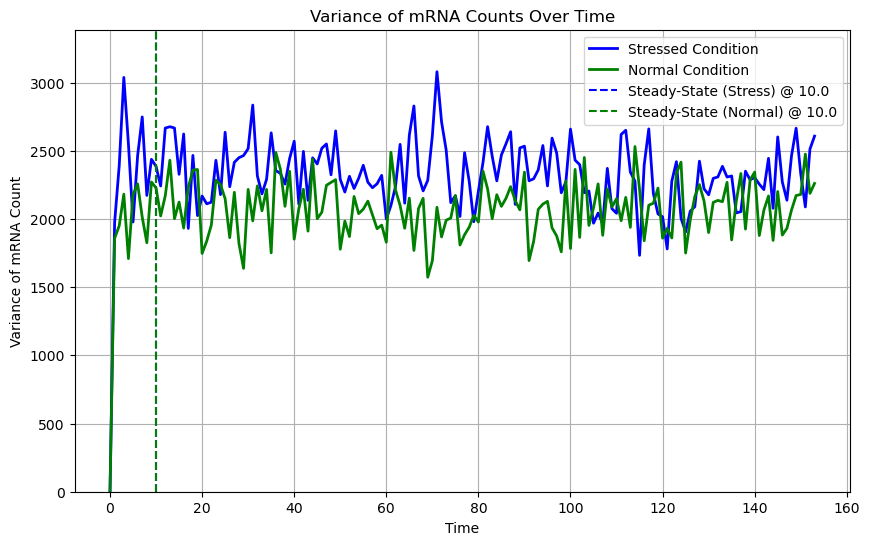


=== Variance at Steady State ===
  Stressed Condition (after 10.0 min): Mean = 59.24, Variance = 2342.92
  Normal Condition (after 10.0 min): Mean = 59.34, Variance = 2091.52


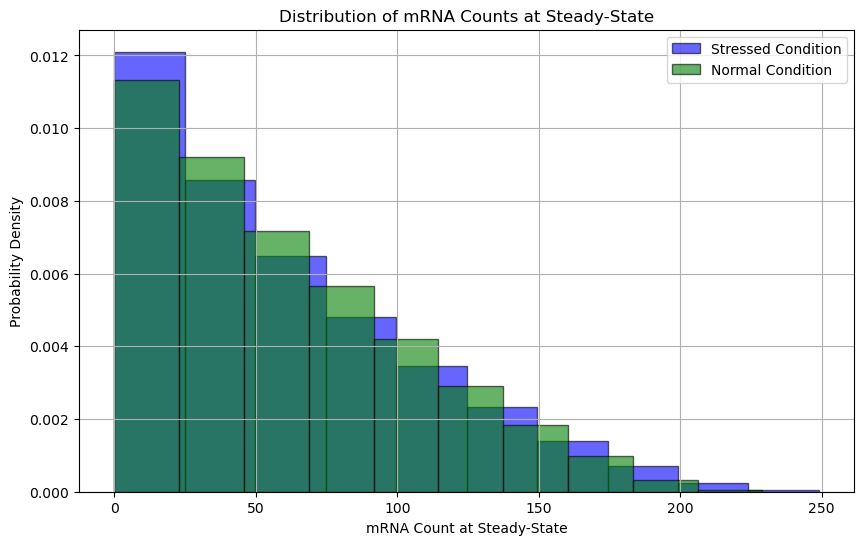

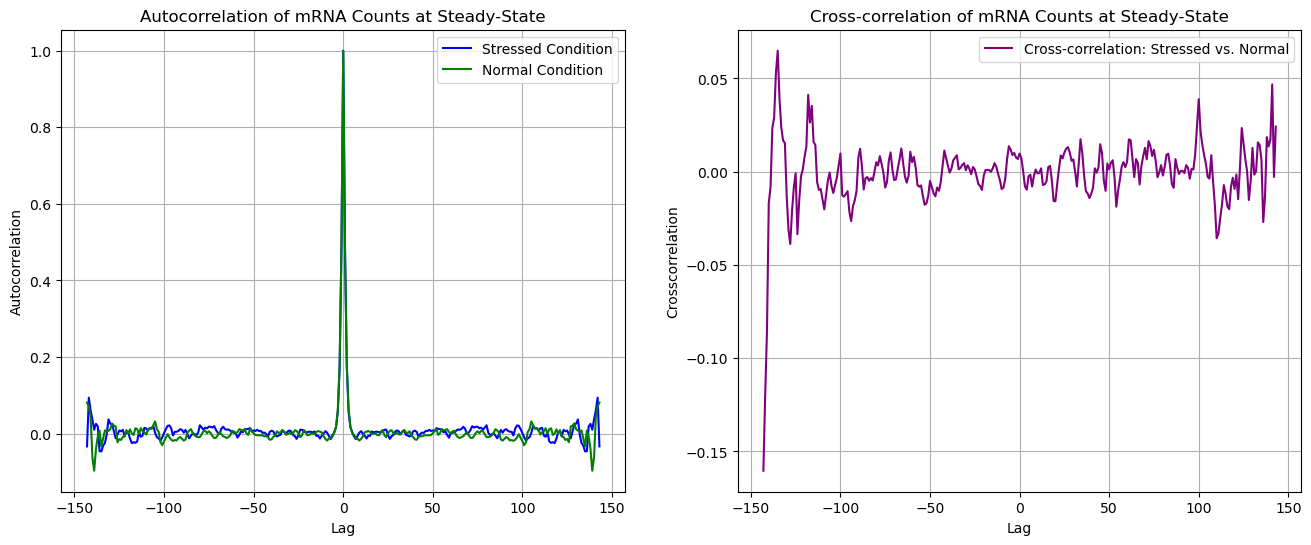

In [86]:
############# SIMULATION ################

# Set up simulation parameters 
# get the min degradation rate
min_d = min([param_set['d'] for param_set in parameter_sets])    
# get the time point after which the system reaches steady state 
steady_state_time = int(10 / min_d)

# !! Use np.arange to make sure evenly spaced values within a given interval, to match how exp data is collected at set time intervals !!
time_points = np.arange(0, 144.0, 1.0)  # Time range: start, stop, step; 
# 144 time points: to match experimental conditions, where typically a photo is taken every 5 min over 12 hours --> 144 time points
# extend time points to account for steady state
extended_time_points = np.arange(time_points[0], 
                                 len(time_points) + steady_state_time, 
                                 time_points[1] - time_points[0])

size = 200  # size of the simulation needs to be big enough for this particular system to reach steady state

# Run the simulation function
df_results = simulate_two_telegraph_model_systems(parameter_sets, extended_time_points, size)

# Save dataset for ML classification
output_file = f"data/mRNA_trajectories_auto_mu_var_fixed_{autocorr_target}_{mu_target}_{variance_target}.csv"
df_results.to_csv(output_file, index=False)

# Extract mRNA trajectories for each condition
stress_trajectories = df_results[df_results['label'] == 0].iloc[:, 1:].values  # Stressed Condition
normal_trajectories = df_results[df_results['label'] == 1].iloc[:, 1:].values  # Normal condition

# report the mean and variance of the mRNA counts at steady state
report =  statistical_report(parameter_sets, stress_trajectories, normal_trajectories)
X_train, X_test, y_train, y_test = load_and_split_data(output_file)
svm_accuracy = svm_classifier(X_train, X_test, y_train, y_test)
rf_accuracy = random_forest_classifier(X_train, X_test, y_train, y_test)
log_reg_accuracy = logistic_regression_classifier(X_train, X_test, y_train, y_test)
random_accuracy = random_classifier(y_test)
pca_plot(output_file)

# Plots
plot_mRNA_trajectory(parameter_sets, extended_time_points, stress_trajectories, normal_trajectories)
plot_mRNA_variance(parameter_sets, extended_time_points, stress_trajectories, normal_trajectories)
plot_mRNA_dist(parameter_sets, stress_trajectories, normal_trajectories)
plot_autocrosscorr(parameter_sets, stress_trajectories, normal_trajectories)

In [36]:
def autocrosscorr_updated(t_max, num_points, d, sigma_u, sigma_b, rho, only_pos=False):
    """
    Calculate autocorrelation of mRNA levels based on the given mathematical formula.

    Parameters
    ----------
    t_max : float
        Maximum absolute lag time to consider.
    num_points : int
        Number of time points to evaluate.
    d : float
        Degradation rate.
    sigma_u : float
        Gene off rate.
    sigma_b : float
        Gene on rate.
    rho : float
        Transcription rate.
    only_pos : boolean (optional)
        If True, return results only for positive lags.

    Returns
    -------
    corr : array
        Autocorrelation values for each lag.
    lags : array
        A 1D array of the lags.
    """

    # Generate symmetric time points for both positive and negative lags
    t_values = np.linspace(-t_max, t_max, num_points)

    # Compute the denominator (remains constant for all time points)
    denominator = (d - sigma_u - sigma_b) * (rho * sigma_u + d * (sigma_u + sigma_b) + (sigma_u + sigma_b) ** 2)
    # prevent division by zero
    denominator = np.where(denominator == 0, 1e-10, denominator)  # Prevent division by zero

    # Compute autocorrelation for each lag
    corr = np.array([
        np.exp(-d * t) * (
            d * np.exp((d - sigma_u - sigma_b) * t) * rho * sigma_u
            - (sigma_u + sigma_b) * (-d**2 + rho * sigma_u + (sigma_u + sigma_b) ** 2)
        ) / denominator
        for t in t_values
    ])

    # Define lags (same length as corr)
    lags = np.linspace(-t_max, t_max, num_points)

    # Return only positive lags if specified
    if only_pos:
        midpoint = len(corr) // 2
        return corr[midpoint:], lags[midpoint:]
    else:
        return corr, lags

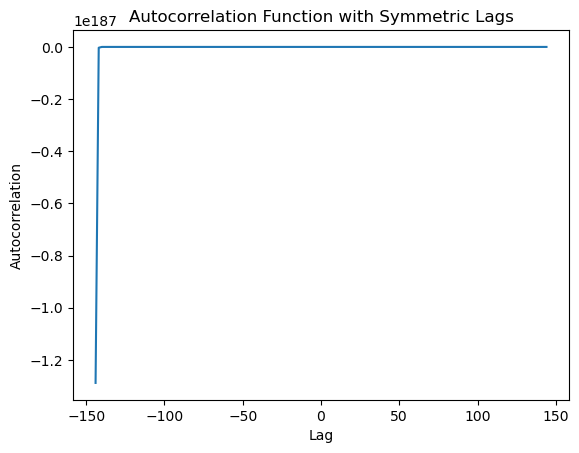

In [41]:
# Define system parameters
# mu_target = 10.0  

# Define activation/deactivation rates for two conditions
sigma_u_stress, sigma_b_stress = 2.0, 1.0  # Stressed Condition

# Define degradation rates
d_stress = 1.0
# Compute corresponding transcription rates (rho) using the given formula
rho_stress = 10

t_max = 144      # Maximum time lag to compute
num_points = 144  # Number of time points to compute

# Compute autocorrelation
corr, lags = autocrosscorr_updated(t_max, num_points, d_stress, sigma_u_stress, sigma_b_stress, rho_stress)

# Plot the results
plt.plot(lags, corr)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation Function with Symmetric Lags")
plt.show()

Autocorrelation Time

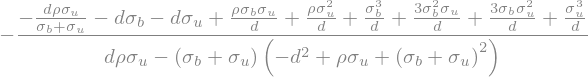

In [47]:
# Define the autocorrelation equation
ACmRNA_eq = sp.exp(-d * t) * (
    d * sp.exp((d - sigma_u - sigma_b) * t) * rho * sigma_u
    - (sigma_u + sigma_b) * (-d**2 + rho * sigma_u + (sigma_u + sigma_b) ** 2)
) / (
    (d - sigma_u - sigma_b) * (rho * sigma_u + d * (sigma_u + sigma_b) + (sigma_u + sigma_b) ** 2)
)

# Autocorrelation time calculation
autocorr_time = sp.integrate(ACmRNA_eq / ACmRNA_eq.subs(t, 0), (t, 0, sp.oo))
autocorr_time

In [69]:
# Importing necessary modules 
import sympy as sp
from sympy import init_printing
from scipy.optimize import fsolve
import numpy as np

# Define symbols
rho, mu, sigma_sq, d, sigma_u, sigma_b, t = sp.symbols(
    'rho mu sigma_sq d sigma_u sigma_b t', real=True, positive=True
)
init_printing(use_unicode=True)

# Define the equations
def equations(vars, sigma_u, sigma_b, d, mu_target, variance_target, autocorr_target):
    rho = vars[0]

    # Mean equation
    mean_eqn = sigma_b * rho / (d * (sigma_b + sigma_u))

    # Variance equation
    variance_eqn = (
        sigma_b * rho / (d * (sigma_b + sigma_u)) +
        ((sigma_u * sigma_b) * rho**2 / (d * (sigma_b + sigma_u + d) * (sigma_u + sigma_b)**2))
    )

    # Define the autocorrelation equation
    ACmRNA_eq = sp.exp(-d * t) * (
        d * sp.exp((d - sigma_u - sigma_b) * t) * rho * sigma_u
        - (sigma_u + sigma_b) * (-d**2 + rho * sigma_u + (sigma_u + sigma_b) ** 2)
    ) / (
        (d - sigma_u - sigma_b) * (rho * sigma_u + d * (sigma_u + sigma_b) + (sigma_u + sigma_b) ** 2)
    )

    # Autocorrelation time calculation
    autocorr_time = sp.integrate(ACmRNA_eq / ACmRNA_eq.subs(t, 0), (t, 0, sp.oo))

    # Define the equation to be solved
    eq1 = mean_eqn - mu_target
    eq2 = variance_eqn - variance_target
    eq3 = autocorr_time - autocorr_target

    return [eq3]

# Target autocorrelation time

autocorr_target = 0.4  # Example target autocorrelation time
variance_target = 500.0
mu_target = 60.0

# Define activation/deactivation rates and degradation rates for the conditions
parameters = {
    "stress": {"sigma_u": 5.0, "sigma_b": 0.5, "d": 1.0},
    "normal": {"sigma_u": 2.5, "sigma_b": 1.0, "d": 1.0}
}

# Store positive rho values for both conditions
rho_values = {}

for condition, param_set in parameters.items():
    # Initial guess for rho this is important to finding a solution that satisfies the equations
    rho_ig = np.arange(1, 1000, 10)
    # sigma_b_ig = np.arange(1, 10000, 10)
    initial_guesses = rho_ig
    
    for initial_guess in initial_guesses:
        solution = fsolve(equations, initial_guess, args=(
            param_set['sigma_u'], param_set['sigma_b'], param_set['d'], mu_target, variance_target, autocorr_target
        ))
        print(f'solution: {solution}')

        solved_equations = equations(solution, param_set['sigma_u'], param_set['sigma_b'], param_set['d'], mu_target, variance_target, autocorr_target)
        print(f'solved_equations: {solved_equations}')

        # Check if the solved equation is close to zero
        if -1e-6 < solved_equations[0] < 1e-6:
            if solution[0] > 0:
                print('Positive solution found with different initial guesses.')
                print(f"Solution for {condition} condition: {solution}")
                rho_values[condition] = solution[0]
                # sigma_b_values[condition] = solution[1]
                #DEBUG
                print(f'Solution: {solution}, Solved equation: {solved_equations}')

                break

# Output the results
print("Calculated rho values:", rho_values)

# Updated Parameter Sets using the calculated rho values
parameter_sets = [
    {"sigma_u": parameters["stress"]["sigma_u"], 
     "sigma_b": parameters["stress"]["sigma_b"], 
     "rho": rho_values["stress"], 
     "d": parameters["stress"]["d"], 
     "label": 0},
     
    {"sigma_u": parameters["normal"]["sigma_u"], 
     "sigma_b": parameters["normal"]["sigma_b"], 
     "rho": rho_values["normal"], 
     "d": parameters["normal"]["d"], 
     "label": 1}
]
############# SIMULATION ################

# # Set up simulation parameters 
# # get the min degradation rate
# min_d = min([param_set['d'] for param_set in parameter_sets])    
# # get the time point after which the system reaches steady state 
# steady_state_time = int(10 / min_d)

# # !! Use np.arange to make sure evenly spaced values within a given interval, to match how exp data is collected at set time intervals !!
# time_points = np.arange(0, 144.0, 1.0)  # Time range: start, stop, step; 
# # 144 time points: to match experimental conditions, where typically a photo is taken every 5 min over 12 hours --> 144 time points
# # extend time points to account for steady state
# extended_time_points = np.arange(time_points[0], 
#                                  len(time_points) + steady_state_time, 
#                                  time_points[1] - time_points[0])

# size = 200  # size of the simulation needs to be big enough for this particular system to reach steady state

# # Run the simulation function
# df_results = simulate_two_telegraph_model_systems(parameter_sets, extended_time_points, size)

# # Save dataset for ML classification
# output_file = f"data/mRNA_trajectories_autocorr_fixed_{autocorr_target}.csv"
# df_results.to_csv(output_file, index=False)

# # Extract mRNA trajectories for each condition
# stress_trajectories = df_results[df_results['label'] == 0].iloc[:, 1:].values  # Stressed Condition
# normal_trajectories = df_results[df_results['label'] == 1].iloc[:, 1:].values  # Normal condition

# # report the mean and variance of the mRNA counts at steady state
# report =  statistical_report(parameter_sets, stress_trajectories, normal_trajectories)
# X_train, X_test, y_train, y_test = load_and_split_data(output_file)
# svm_accuracy = svm_classifier(X_train, X_test, y_train, y_test)
# rf_accuracy = random_forest_classifier(X_train, X_test, y_train, y_test)
# log_reg_accuracy = logistic_regression_classifier(X_train, X_test, y_train, y_test)
# random_accuracy = random_classifier(y_test)
# pca_plot(output_file)

# # Plots
# plot_mRNA_trajectory(parameter_sets, extended_time_points, stress_trajectories, normal_trajectories)
# plot_mRNA_variance(parameter_sets, extended_time_points, stress_trajectories, normal_trajectories)
# plot_mRNA_dist(parameter_sets, stress_trajectories, normal_trajectories)
# plot_autocrosscorr(parameter_sets, stress_trajectories, normal_trajectories)

solution: [-5.4872093]
solved_equations: [-5.55111512312578e-17]
solution: [-5.4872093]
solved_equations: [3.33066907387547e-15]
solution: [-5.4872093]
solved_equations: [-5.55111512312578e-17]
solution: [-5.4872093]
solved_equations: [-5.08482145278322e-14]
solution: [-5.4872093]
solved_equations: [9.99200722162641e-15]
solution: [-5.4872093]
solved_equations: [1.33226762955019e-15]
solution: [-5.4872093]
solved_equations: [6.66133814775094e-15]
solution: [-5.4872093]
solved_equations: [-5.55111512312578e-17]
solution: [-5.4872093]
solved_equations: [-5.55111512312578e-17]
solution: [-5.4872093]
solved_equations: [2.00728322852228e-13]


/tmp/ipykernel_1654302/2428837825.py:66: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  solution = fsolve(equations, initial_guess, args=(


solution: [101.]
solved_equations: [0.769797839700752]
solution: [111.]
solved_equations: [0.770815219482168]
solution: [121.]
solved_equations: [0.771673819742489]
solution: [131.]
solved_equations: [0.772408120290857]
solution: [141.]
solved_equations: [0.773043291504311]
solution: [151.]
solved_equations: [0.773598137556405]
solution: [161.]
solved_equations: [0.774086989430433]
solution: [171.]
solved_equations: [0.774520960375577]
solution: [181.]
solved_equations: [0.774908801005001]
solution: [191.]
solved_equations: [0.775257495469456]
solution: [201.]
solved_equations: [0.775572685781669]
solution: [211.]
solved_equations: [0.775858979434501]
solution: [221.]
solved_equations: [0.776120176120176]
solution: [231.]
solved_equations: [0.776359437329414]
solution: [241.]
solved_equations: [0.776579414943308]
solution: [251.]
solved_equations: [0.776782349937492]
solution: [261.]
solved_equations: [0.776970149000729]
solution: [271.]
solved_equations: [0.777144444626019]
solution: 

KeyError: 'stress'